# [LVV-T11258] - Settling Time After a Slew

Notebook containing data analysis for the [LVV-T11258] test case.  

[LVV-T11258]: https://jira.lsstcorp.org/browse/LVV-11258

Some pending items(July 8th 2023) --> add as issues:
1. Get some RMS requirements 
2. Tweak parameters for stationarity, for a robust measurement


### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

import warnings
warnings.filterwarnings('ignore')

In [3]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define functions

#### determine settling time

In [4]:
def determineSettleTime(df_ims, #input data frame
                        reference_t = '2023-06-01T06:00:0Z', #time for slew stop
                        lo_delta_t = 5, #in seconds
                        hi_delta_t = 30, #in seconds
                        imsColumn = 'xPosition', #IMS column
                        rmsReq = 1e-2, #requirement in appropriate units
                        req_delta_t = 3, #time for settling, in seconds
                        lapse = 200, pvalue = 0.05): 
    
    if 'Position' in imsColumn:
        units = 'mm'
    else:
        units = 'deg'

    #T0 and T1 defines the window for requirement to be met
    T0 = pd.to_datetime(reference_t)
    T1 = T0 + pd.to_timedelta(req_delta_t,unit='s')
    # delta_window is the time window for plot and reference for mean, before and after T0
    delta_window = [pd.Timedelta(lo_delta_t, "seconds"),pd.Timedelta(hi_delta_t, "seconds")] 
    #zoom around the T0 of interest
    TZoom = [T0-delta_window[0],  T0+delta_window[1]] 
      
    targetVariablePlot = df_ims[imsColumn][TZoom[0]:TZoom[1]] #complete plot range
    targetVariableWindow = df_ims[imsColumn][T0:T1] #from slew stop to end of requwindow
    idxT0 = df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T0)], method='nearest')]
    idxTend = df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T0+delta_window[1])], method='nearest')]
    targetVariableReference = [df_ims[imsColumn][idxT0],float(df_ims[imsColumn][idxTend])] 
    #targetVariableReference = [df_ims[imsColumn][idxT0],df_ims[imsColumn][-1]] 
    #at slew stop and end of plot
    
    if len(targetVariablePlot.index) == 0:
        print('Data frame is empty')
        return -1
    
    #rms of difference wrt to end of plot, of values within requirement in window
    rms = np.std(targetVariableWindow-targetVariableReference[1]) 
    
    title = imsColumn
    label = imsColumn + '(' + units +') wrt value at slew stop'

    fig = plt.figure()
    plt.plot(targetVariablePlot-targetVariableReference[0][0],
             color='red', lw="0.5", label=label)
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label='Slew stop')
    #plt.axhline(-rmsReq)
    #plt.axhline(rmsReq)
    plt.xlabel("Time [UTC]")
    plt.ylabel(label)
    plt.text(0.25, 0.92, 'RMS =' + ' {:.2e} '.format(rms) + units + 
             ' in 3s window, wrt value at end of plot', 
             transform=fig.transFigure)
    fig.autofmt_xdate()
    fig.tight_layout()

    ## recomputing RMS for the whole range since T0
    targetVariable = df_ims[imsColumn][T0:TZoom[1]]
    rms = (targetVariable - targetVariableReference[1]).rolling(20).std()
    plt.plot(rms, label='RMS wrt value at the end of plot,\n from slew stop')
    plt.axvspan(T0, T1, alpha=0.5, color='green', label='3s tolerance window')
    plt.legend(loc="upper right", fontsize = "8")
    #print(rms) 

    ## compute time for settling using the Augmented Dickey-Fuller test
    ## in this test, if you discard the null hypothesis, stationarity is found
    ## https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test
    fig = plt.figure()    
    rms = rms.dropna() # remove NaNs created by the rolling function
    ##lapse = 400 # to be adjusted
    ##pvalue = 0.05 ## if lower, test is less tolerant to finding stationarity, to be adjusted
    k= 0
    for i in range(0,len(rms)-lapse):# lapse is the number of forward events that are used for
                                     # the RMS to measure stationarity 
        adf = adfuller(rms[i:i+lapse], autolag='AIC')
        #print(i,rms.index[i],adf[1],len(rms)-lapse)
        if adf[1] < pvalue: # is non-stationary if null hypothesis is true (large p-value)
            #print(i, i+lapse, adf[1], pvalue)
            k = i+lapse #stationarity is reached at the time stamp at the end of the lapse 
                        #used for RMS
            #print(k, rms.index[k])
            break
    

    plt.plot(rms)
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label='Slew stop')
    plt.axvline(rms.index[k], lw="1.25", c="green", ls="dashed", label='Settled')
    plt.xlabel("Time [UTC]")
    plt.ylabel('RMS wrt value at the end of plot ('+units+')')    
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.text(0.50, 0.93, 'Slew stop =' + t1.strftime('%H:%M:%S.%f'), transform=fig.transFigure)        
    plt.text(0.50, 0.90, 'Settling time (ADF test) =' + rms.index[k].strftime('%H:%M:%S.%f'), transform=fig.transFigure)        
    time_to_settle = rms.index[k]-t1
    print("Time to settle:",lapse,k,time_to_settle.total_seconds(),"s")
    return rms.index[k]
    

#### compare IMS vs mount data

In [26]:
def compareIMSMount(df_ims,
                   df_mtmount_ele,
                   df_mtmount_azi,
                   reference_t = '2023-06-01 06:53:37.326',
                   lo_delta_t = 5, #in seconds
                   hi_delta_t = 60): #in seconds
    
    fig,axs = plt.subplots(5,1, dpi=125, figsize=(6,8))
    t_start_plot = pd.to_datetime(reference_t) - pd.to_timedelta(lo_delta_t,unit='s') ##correcting by hand for TAI, is this correct?
    t_end_plot = pd.to_datetime(reference_t) + pd.to_timedelta(hi_delta_t,unit='s')

    ax = axs[0]
    actpos_ele = df_mtmount_ele['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_ele,color='red', lw="0.5")
    ax.axvline(pd.to_datetime(reference_t), lw="0.5", c="k")
    ax.set_ylabel("Elevation \nPosition\n[deg]")
    
    ax = axs[1]
    actpos_azi = df_mtmount_azi['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_azi,color='red', lw="0.5")
    ax.axvline(pd.to_datetime(reference_t), lw="0.5", c="k")
    ax.set_ylabel("Azimuth \nPosition\n[deg]")

    t_start_plot = pd.to_datetime(reference_t) - pd.to_timedelta(lo_delta_t,unit='s') 
    t_end_plot = pd.to_datetime(reference_t) + pd.to_timedelta(hi_delta_t,unit='s')
    
    plotstring = ['xPosition','yPosition','zPosition']
    plotrange = np.arange(len(plotstring))    
    for i in plotrange:
        ax = axs[i+2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos,color='red', lw="0.5")
        ax.axvline(pd.to_datetime(reference_t), lw="0.5", c="k")
        ax.set_ylabel(plotstring[i] + ' \n[mm]')
    ax.set_xlabel('UTC')
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(reference_t)
    fig.tight_layout()
    ### TBD: use a delta time wrt slew stop in x-label

### Get slew stops

In [6]:
# Select data from a given date
dayObs =  20230717 #20230627 #20230710 contains the first large slew motions
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 240 slews and 215 tracks


### Load data

In [7]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

#### Using eventMaker 

In [12]:
## Some settings
# define specific slew
i_slew = 78
# define padding after end of slew
postPadding = 60 # in seconds

In [13]:
t0 = Time(slews[i_slew].begin, format='isot', scale='utc')
t0 = pd.to_datetime(t0.value, utc=True) # astropy Time to Timestamp conversion
t1 = Time(slews[i_slew].end, format='isot', scale='utc')
t1 = pd.to_datetime(t1.value, utc=True) # astropy Time to Timestamp conversion
print('Slew stop at:',t1)

# Get IMS data
# Note that we need data beyond the associated to the slew stop, 
# which just covers the slew itself, ie, while the telescope is moving (TBC)
df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', 
                    event=slews[i_slew], 
                    postPadding = postPadding)
df_ims = df_ims[all_columns]
# Convert meter to milimeter 
df_ims[pos_columns] = df_ims[pos_columns] * 1e3


Slew stop at: 2023-07-18 05:02:46.159000+00:00


In [14]:
# Get mount data
df_mtmount_ele = getEfdData(client,'lsst.sal.MTMount.elevation', 
                            event=slews[i_slew], 
                            postPadding = postPadding)
df_mtmount_azi = getEfdData(client,'lsst.sal.MTMount.azimuth', 
                            event=slews[i_slew], 
                            postPadding = postPadding)

### Look at data

reference_t: 2023-07-18 05:02:46.159000+00:00
t_start: 2023-07-18 05:02:36.159000+00:00
t_end: 2023-07-18 05:03:46.159000+00:00
xPosition
2023-07-18 05:02:36.159000+00:00
yPosition
2023-07-18 05:02:36.159000+00:00
zPosition
2023-07-18 05:02:36.159000+00:00


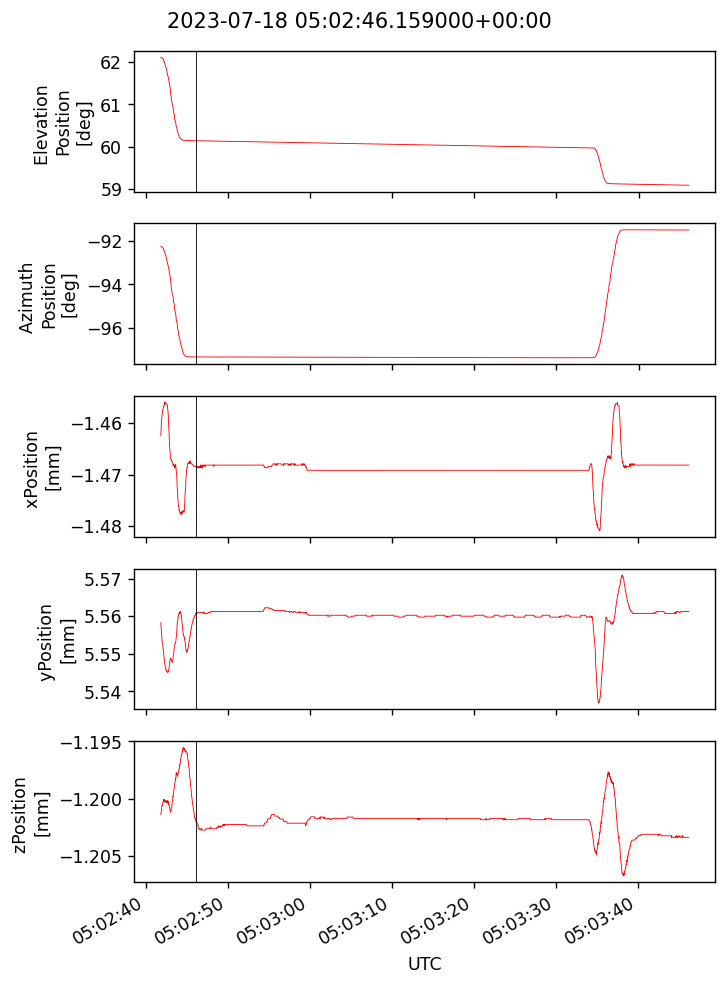

In [27]:
%matplotlib inline
compareIMSMount(df_ims,df_mtmount_ele,df_mtmount_azi,
                t1,10,pd.to_timedelta(postPadding, unit="s"))

In [41]:
reference_t = '2023-07-18 05:03:10.159000+00:00'
t_start = pd.to_datetime(reference_t) - pd.to_timedelta(5,unit='s') ##correcting by hand for TAI, is this correct?
t_end = pd.to_datetime(reference_t) + pd.to_timedelta(15,unit='s')
for column in pos_columns:
    val = df_ims[column][t_start:t_end]
    #plt.plot(val)
    print(column,val.std()*1000,'microns')
for column in rot_columns:
    val = df_ims[column][t_start:t_end]
    #plt.plot(val)
    print(column,val.std(),'degrees')

xPosition 0.0009623137691034618 microns
yPosition 0.17500524086638167 microns
zPosition 0.041387621137647546 microns
xRotation 2.3178622800211545e-07 degrees
yRotation 1.153588904735191e-06 degrees
zRotation 8.346150417798672e-07 degrees


### Run test

In [ ]:
req_delta_t = 3 ## seconds
req_rms = 1e-2 

In [ ]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'xRotation', 
                    rmsReq = req_rms, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

In [ ]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'xRotation', 
                    rmsReq = req_rms, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

In [ ]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'xRotation', 
                    rmsReq = req_rms, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

In [ ]:
%matplotlib inline
determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = postPadding,
                    imsColumn = 'xRotation', 
                    rmsReq = req_rms, 
                    req_delta_t = req_delta_t,
                    lapse = 600, pvalue = 0.001)

In [ ]:
for i in [10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 200, 300, 600, 900]:
    #check stability of result (settle time) for several lapse (i) values
    determineSettleTime(df_ims = df_ims, 
                    reference_t = t1, 
                    lo_delta_t = 5,
                    hi_delta_t = 60,
                    imsColumn = 'zRotation', 
                    rmsReq = req_rms, 
                    req_delta_t = req_delta_t,
                    lapse = i, pvalue = 0.001)
    ##print(settle)